In [3]:
import xgboost as xgb

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import log_loss
seed=2300
%matplotlib inline

In [5]:
train_df = pd.read_csv('train.csv') #index_col = 0将id作为index
test_df = pd.read_csv('test.csv')
# prices = pd.DataFrame({'energy':train_df['formation_energy_ev_natom'], 'log(price+1)':np.log1p(train_df['formation_energy_ev_natom'])})
# prices.hist()

In [4]:
train_df.shape
test_df.shape

(600, 12)

In [5]:
# 查找缺失值
# train_df.count()
train_df.describe()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,1200.500000,141.517917,61.679167,0.385439,0.308601,0.305958,10.030005,7.086977,12.593288,90.243666,92.398971,94.787600,0.187614,2.077205
std,692.964646,84.715548,22.598337,0.265566,0.233717,0.263198,5.645457,1.890330,5.450746,1.333655,5.299734,25.868516,0.104100,1.006845
min,1.000000,12.000000,10.000000,0.000000,0.000000,0.000000,3.037000,2.942300,5.672500,82.744100,81.641300,29.727400,0.000000,0.000100
25%,600.750000,33.000000,40.000000,0.166700,0.093800,0.062500,6.141100,5.833625,9.298000,89.999700,90.000900,89.998700,0.105600,1.278500
50%,1200.500000,194.000000,80.000000,0.375000,0.281200,0.250000,9.537450,6.382950,10.125000,90.001700,90.003550,90.000400,0.181800,1.907850
75%,1800.250000,206.000000,80.000000,0.583300,0.468800,0.468800,10.292100,9.093450,14.372050,90.006200,90.014400,119.998325,0.256275,2.761950
max,2400.000000,227.000000,80.000000,1.000000,1.000000,1.000000,24.913400,10.290300,25.346000,101.229800,106.168200,120.053500,0.657200,5.286100


### EDA

/Users/baobao/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


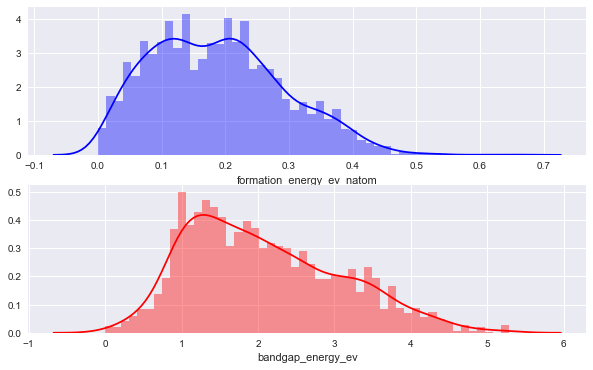

In [6]:
# 单个数值/类别计数
# train_df['formation_energy_ev_natom'].value_counts()
fig,ax = plt.subplots(2,1,figsize=(10,6))
ax1,ax2 = ax.flatten()
sns.distplot(train_df['formation_energy_ev_natom'],bins=50,ax=ax1,color='b')
sns.distplot(train_df['bandgap_energy_ev'],bins=50,ax=ax2,color='r')

/Users/baobao/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


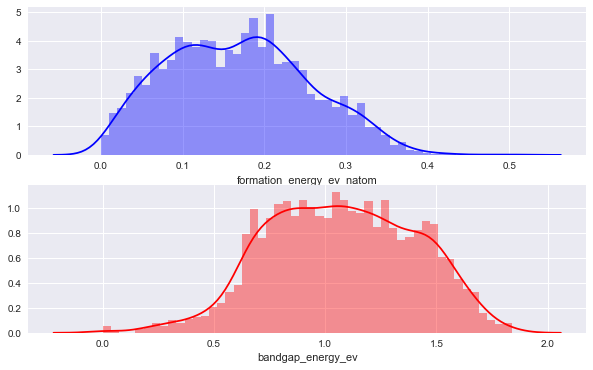

In [7]:
fig,ax = plt.subplots(2,1,figsize=(10,6))
ax1,ax2 = ax.flatten()
sns.distplot(np.log1p(train_df['formation_energy_ev_natom']),bins=50,ax=ax1,color='b')
sns.distplot(np.log1p(train_df['bandgap_energy_ev']),bins=50,ax=ax2,color='r')

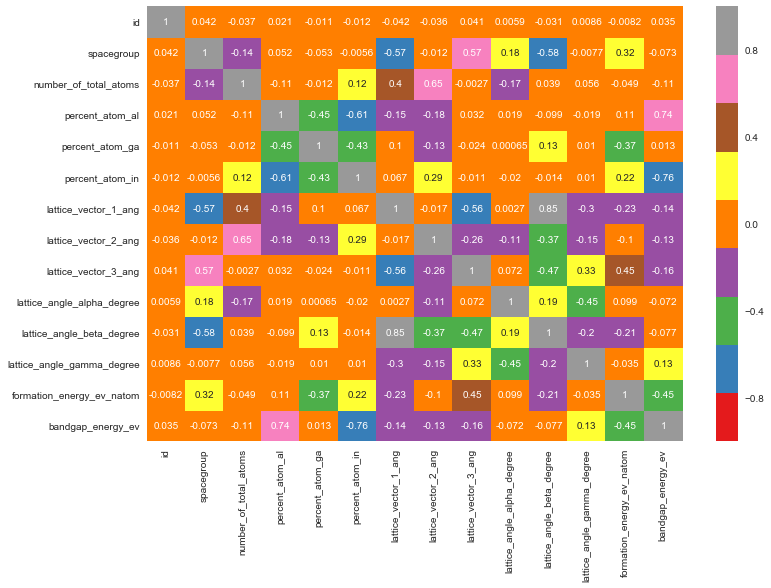

In [8]:
cor = train_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(cor,cmap='Set1',annot=True)

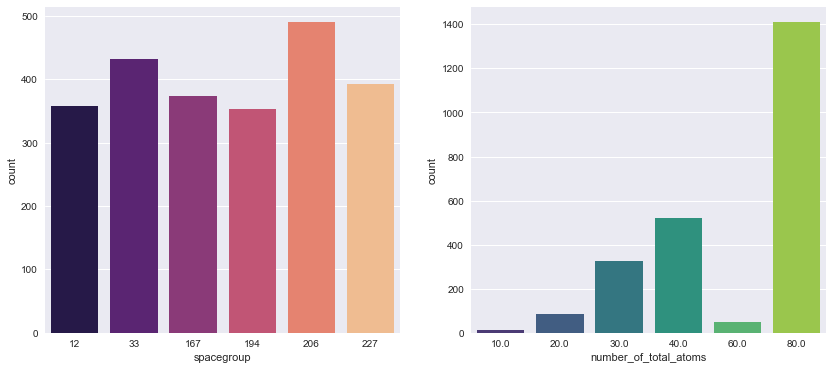

In [9]:
fig,ax = plt.subplots(1,2, figsize=(14,6))
ax1, ax2 = ax.flatten()
sns.countplot(train_df['spacegroup'], palette = 'magma', ax = ax1)
sns.countplot(x = train_df['number_of_total_atoms'], palette = 'viridis', ax = ax2)

In [10]:
pd.crosstab(train_df['number_of_total_atoms'],train_df['spacegroup'])

spacegroup,12,33,167,194,206,227
number_of_total_atoms,,,,,,
10.0,0,0,0,13,0,0
20.0,84,0,0,0,0,0
30.0,0,0,326,0,0,0
40.0,0,126,0,0,0,393
60.0,0,0,48,0,0,0
80.0,274,306,0,340,490,0


### Preprocessing

In [11]:
train_df.describe()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,1200.500000,141.517917,61.679167,0.385439,0.308601,0.305958,10.030005,7.086977,12.593288,90.243666,92.398971,94.787600,0.187614,2.077205
std,692.964646,84.715548,22.598337,0.265566,0.233717,0.263198,5.645457,1.890330,5.450746,1.333655,5.299734,25.868516,0.104100,1.006845
min,1.000000,12.000000,10.000000,0.000000,0.000000,0.000000,3.037000,2.942300,5.672500,82.744100,81.641300,29.727400,0.000000,0.000100
25%,600.750000,33.000000,40.000000,0.166700,0.093800,0.062500,6.141100,5.833625,9.298000,89.999700,90.000900,89.998700,0.105600,1.278500
50%,1200.500000,194.000000,80.000000,0.375000,0.281200,0.250000,9.537450,6.382950,10.125000,90.001700,90.003550,90.000400,0.181800,1.907850
75%,1800.250000,206.000000,80.000000,0.583300,0.468800,0.468800,10.292100,9.093450,14.372050,90.006200,90.014400,119.998325,0.256275,2.761950
max,2400.000000,227.000000,80.000000,1.000000,1.000000,1.000000,24.913400,10.290300,25.346000,101.229800,106.168200,120.053500,0.657200,5.286100


In [6]:
# Degree to radian
train_df['alpha_rad'] = np.radians(train_df['lattice_angle_alpha_degree'])
train_df['beta_rad'] = np.radians(train_df['lattice_angle_beta_degree'])
train_df['gamma_rad'] = np.radians(train_df['lattice_angle_gamma_degree'])

test_df['alpha_rad'] = np.radians(test_df['lattice_angle_alpha_degree'])
test_df['beta_rad'] = np.radians(test_df['lattice_angle_beta_degree'])
test_df['gamma_rad'] = np.radians(test_df['lattice_angle_gamma_degree'])

In [7]:
# 提取label
col = ['formation_energy_ev_natom','bandgap_energy_ev']
X = train_df.drop(['id'] + col,axis=1)
y = train_df[col]
test_df=test_df.drop(['id'],axis=1) # 删除列

In [8]:
index = []
for i in range(2401,2401+len(test_df)):
    index.append(i)
test_df = test_df.set_index([index])
all_df= pd.concat((X,test_df), axis = 0)
# X = all_df.loc[train_df.index]

In [9]:
def vol(df):
    """
    volume of the parallelepiped unit cell
    """
    volumn = df['lattice_vector_1_ang']*df['lattice_vector_2_ang']*df['lattice_vector_3_ang']*np.sqrt(
    1 + 2*np.cos(df['alpha_rad'])*np.cos(df['beta_rad'])*np.cos(df['gamma_rad'])
    -np.cos(df['alpha_rad'])**2
    -np.cos(df['beta_rad'])**2
    -np.cos(df['gamma_rad'])**2)
    df['volumn'] = volumn

In [10]:
vol(all_df)
all_df.head()

,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,alpha_rad,beta_rad,gamma_rad,volumn
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,1.570842,1.570836,1.570826,781.052081
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,1.571121,1.570761,2.094439,782.500110
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,1.587705,1.590393,0.532648,391.227531
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,1.570601,1.571004,2.094425,293.377334
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,1.570727,1.570807,2.094208,944.713843


In [11]:
# Atomic density
all_df['density'] = all_df['number_of_total_atoms'] / all_df['volumn']

In [12]:
# 标准化
# all_df = preprocessing.scale(all_df) 结果变为array
col_means= all_df.mean()
col_std= all_df.std()
all_df = (all_df - col_means)/col_std

In [13]:
# 检验NaN method 2
# null = pd.isnull(train_df["density"])
# len(train_df['density'][null == False])

In [17]:
def mean_median_feature(df):
        dmean = df.mean()
        dmedian = df.median()
        # q0_1 = df.quantile(0.1)
        # q0_99 = df.quantile(0.99)
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)
        col = df.columns
        del_col = ['spacegroup','number_of_total_atoms','id','formation_energy_ev_natom','bandgap_energy_ev']
        col = [w for w in col if w not in del_col]
        for c in col:
            # df['mean_'+c] = (df[c] > dmean[c]).astype(np.uint8)
            # df['median_'+c] = (df[c] > dmedian[c]).astype(np.uint8)
            # df['q0_1_'+c] = (df[c] < q0_1[c]).astype(np.uint8)
            # df['q0_99_'+c] = (df[c] > q0_99[c]).astype(np.uint8)
            df['q1_'+c] = (df[c] < q1[c]).astype(np.uint8)
            df['q3_'+c] = (df[c] > q3[c]).astype(np.uint8)
            
        print('Shape',df.shape)

In [18]:
mean_median_feature(all_df)

Shape (3000, 100)


In [19]:
# one hot encoding
all_df['spacegroup'].dtypes
all_df['spacegroup']=all_df['spacegroup'].astype(str)
all_df['number_of_total_atoms']=all_df['number_of_total_atoms'].astype(str)
# pd.get_dummies(all_df['spacegroup'],prefix='spacegrup').head()
all_dummy_df = pd.get_dummies(all_df)
# all_dummy_df.drop(['spacegroup', 'number_of_total_atoms'], axis=1)

In [20]:
X = all_dummy_df.loc[train_df.index]
TEST = all_dummy_df.loc[test_df.index]
X.shape
TEST.shape

(600, 110)

### model & cross validation

In [21]:
# 训练集 X 测试集 TEST 模型Linear Regression
kf = KFold(n_splits=5,random_state=seed,shuffle=True)
cv_score =[]
pred_test_full_1 = np.zeros((TEST.shape[0],kf.n_splits))
pred_test_full_2 = np.zeros((TEST.shape[0],kf.n_splits))
lr = LinearRegression()

for i, (train_index, valid_index) in enumerate(kf.split(X)):
    print('{} of Kfold {}'.format(i+1,kf.n_splits))
    xtrain, xvalid = X.loc[train_index], X.loc[valid_index]
    ytrain, yvalid = y.loc[train_index], y.loc[valid_index]
    
    ##Building model for col[0]
    lr.fit(xtrain,ytrain[col[0]])
    pred_test_full_1[:,i] = lr.predict(TEST)
    score = lr.score(xvalid,yvalid[col[0]])
    cv_score.append(score)
    print('R square for {} is {''} :'.format(col[0],score))
    
    ##Building model for col[1]
    lr.fit(xtrain,ytrain[col[1]])
    pred_test_full_2[:,i] = lr.predict(TEST)
    score = lr.score(xvalid,yvalid[col[1]])
    print('R square for {} is {}:'.format(col[1],score))
    cv_score.append(score)
    

1 of Kfold 5
R square for formation_energy_ev_natom is 0.8211082832400898 :
R square for bandgap_energy_ev is 0.9427954189748997:
2 of Kfold 5
R square for formation_energy_ev_natom is 0.7516474998679882 :
R square for bandgap_energy_ev is 0.9322465739805201:
3 of Kfold 5
R square for formation_energy_ev_natom is 0.7790045483868244 :
R square for bandgap_energy_ev is 0.943745311139653:
4 of Kfold 5
R square for formation_energy_ev_natom is 0.7277446496754416 :
R square for bandgap_energy_ev is 0.9521296717845239:
5 of Kfold 5
R square for formation_energy_ev_natom is 0.8020183292406254 :
R square for bandgap_energy_ev is 0.9408357927910552:


In [25]:
y_pred = np.zeros((TEST.shape[0],len(col)))
y_pred[:,0],y_pred[:,1] = pred_test_full_1.mean(axis=1), pred_test_full_2.mean(axis=1)
y_pred[y_pred <= 0] = 1e-5

submit = pd.DataFrame({'formation_energy_ev_natom':y_pred[:,0],'bandgap_energy_ev':y_pred[:,1]})
submit
# submit.to_csv('lr_conductor.csv',index=False)

,bandgap_energy_ev,formation_energy_ev_natom
0,1.547211,0.201884
1,3.863916,0.083376
2,3.448358,0.153411
3,3.198694,0.027864
4,1.503253,0.145980
5,4.328952,0.098349
6,3.349768,0.048804
7,2.040707,0.097943
8,2.877908,0.017089
9,3.005109,0.236139


In [26]:
# Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
alphas = np.logspace(-3,2,50)
test_scores1 = []
test_scores2 = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score1 = np.sqrt(-cross_val_score(clf, X, y['bandgap_energy_ev'], cv = 10, scoring = 'neg_mean_squared_error'))
    test_score2 = np.sqrt(-cross_val_score(clf, X, y['formation_energy_ev_natom'], cv = 10, scoring = 'neg_mean_squared_error'))
    test_scores1.append(np.mean(test_score1))
    test_scores2.append(np.mean(test_score2))

In [27]:
sum(test_scores1) / float(len(test_scores1))
sum(test_scores2) / float(len(test_scores2))

0.049885563954640638

0.042919342601287783

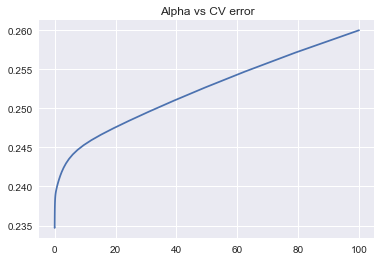

In [28]:
plt.plot(alphas, test_scores1)
# plt.plot(alphas, test_scores2)
plt.title('Alpha vs CV error')
# alphas[24]
alphas[16]

### Ensemble

In [29]:
# random forest 
from sklearn.ensemble import RandomForestRegressor

In [30]:
max_features = [.1,.3,.5,.7,.9,.99]
test_scores1 = []
test_scores2 = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators = 200, max_features = max_feat)
    test_score1 = np.sqrt(-cross_val_score(clf, X, y['bandgap_energy_ev'], cv = 5, scoring='neg_mean_squared_error'))
    test_score2 = np.sqrt(-cross_val_score(clf, X, y['formation_energy_ev_natom'], cv = 5, scoring='neg_mean_squared_error'))
    test_scores1.append(np.mean(test_score1))
    test_scores2.append(np.mean(test_score2))
# 0.3

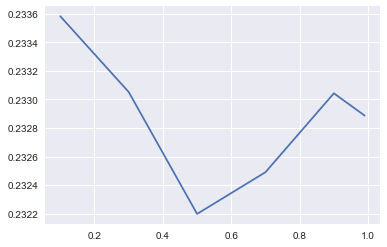

In [31]:
plt.plot(max_features, test_scores1)

In [32]:
ridge = Ridge(0.28)
# bagging calculate bandgap_energy_ev
from sklearn.ensemble import BaggingRegressor
# 定义分类器个数
params = [1,15,20,25,30,40]
test_scores_band = []
for param in params:
    clf = BaggingRegressor(n_estimators = param, base_estimator = ridge)
    test_score_band = np.sqrt(-cross_val_score(clf, X, y['bandgap_energy_ev'], cv = 10, scoring='neg_mean_squared_error'))
    test_scores_band.append(np.mean(test_score_band))

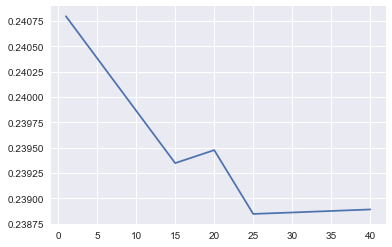

In [33]:
plt.plot(params, test_scores_band)

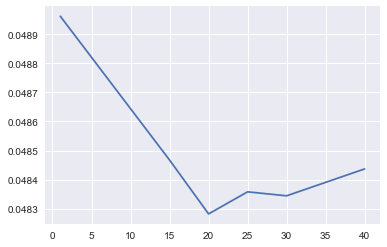

In [34]:
ridge = Ridge(0.04)
# bagging calculate formation_energy_ev_natom
test_scores_format = []
for param in params:
    clf = BaggingRegressor(n_estimators = param, base_estimator = ridge)
    test_score_format = np.sqrt(-cross_val_score(clf, X, y['formation_energy_ev_natom'], cv = 10, scoring='neg_mean_squared_error'))
    test_scores_format.append(np.mean(test_score_format))
plt.plot(params, test_scores_format)

In [37]:
# Boosting
from sklearn.ensemble import AdaBoostRegressor
test_scores_band = []
params = [10, 15, 20, 25, 30, 35, 40, 45, 50]
for param in params:
    clf = AdaBoostRegressor(n_estimators = param, base_estimator = ridge)
    test_score_band = np.sqrt(-cross_val_score(clf, X, y['bandgap_energy_ev'], cv = 10, scoring='neg_mean_squared_error'))
    test_scores_band.append(np.mean(test_score_band))

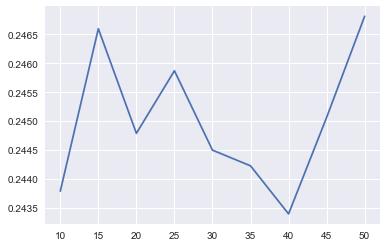

In [39]:
plt.plot(params, test_scores_band)

In [40]:
test_scores_formats = []
for param in params:
    clf = AdaBoostRegressor(n_estimators = param, base_estimator = ridge)
    test_score_format = np.sqrt(-cross_val_score(clf, X, y['formation_energy_ev_natom'], cv = 10, scoring='neg_mean_squared_error'))
    test_scores_formats.append(np.mean(test_score_format))
test_scores_formats

[0.05675186888572635,
 0.056950786826001631,
 0.057251655549455757,
 0.056271018943145845,
 0.058236766765716694,
 0.056386351371472535,
 0.056230696604604405,
 0.056597805680699165,
 0.056763422176633049]

In [41]:
# XGboost
from xgboost import XGBRegressor

In [42]:
params = [1,2,3,4,5,6]
test_scores_band = []
for param in params:
    clf = XGBRegressor(max_depth = param)
    test_score_band = np.sqrt(-cross_val_score(clf, X, y['bandgap_energy_ev'], scoring='neg_mean_squared_error'))
    test_scores_band.append(np.mean(test_score_band))

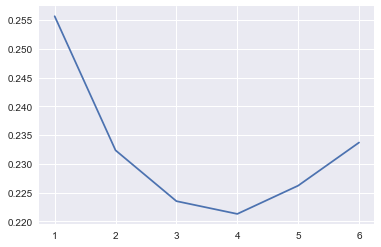

In [43]:
plt.plot(params, test_scores_band)

In [44]:
test_scores_formats = []
for param in params:
    clf = XGBRegressor(max_depth = param)
    test_scores_format = np.sqrt(-cross_val_score(clf, X, y['formation_energy_ev_natom'], scoring='neg_mean_squared_error'))
    test_scores_formats.append(np.mean(test_scores_format))

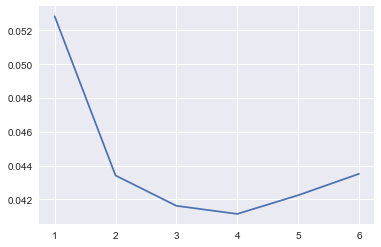

In [45]:
plt.plot(params, test_scores_formats)

In [1]:
# LightGBM
import lightgbm as lgb
import multiprocessing

In [23]:
# log1p
target_fe = np.log1p(train_df.formation_energy_ev_natom)
target_be = np.log1p(train_df.bandgap_energy_ev)

In [28]:
# target_fe
target_fe.values.ravel()
type(target_fe)

pandas.core.series.Series

In [32]:
def cv_train_model(X, y, 
                   verbose_eval=None, 
                   early_stopping_rounds=None,
                   params=None):
    if type(y) is pd.core.frame.DataFrame:
        y = y.values.ravel()
    
    # dataset
    dstrain = lgb.Dataset(X, label=y)
    max_boost_round = 4000
    
    if params is None:
        lgb_params = {
            'objective': 'regression_l2',
            'learning_rate': 0.008,
            'num_threads': 4, # multiprocessing.cpu_count(),
            'max_depth': 4,
            'min_data_in_leaf': 23,
            'feature_fraction': 0.93,
            'bagging_fraction': 0.93,
            'bagging_freq': 1,
            'lambda_l2': 1e2,
            'metric': ['mse']
        }
    print('lgb cv and training...')
    
    if verbose_eval is None:
        verbose_eval = int(max_boost_round/30)
    if early_stopping_rounds is None:
        early_stopping_rounds = int(max_boost_round/10)
        
    cv_lgb = lgb.cv(lgb_params, dstrain,
                    num_boost_round=max_boost_round,
                    nfold=10,
                    stratified=False,
                    verbose_eval=verbose_eval,
                    early_stopping_rounds=early_stopping_rounds,
                    show_stdv=False)
    
    best_round = np.argmin(cv_lgb['l2-mean']) # 返回最值所在的索引,cv的最好结果
    best_cv_mean = np.min(cv_lgb['l2-mean'])
    print('best round', best_round)
    print('best mse-mean', best_cv_mean)
    
    model_lgb = lgb.train(lgb_params, dstrain, 
                          num_boost_round=best_round,
                          valid_sets=dstrain,
                          verbose_eval=verbose_eval)
    print('lgb cv and training finished...')
    
    # 返回训练最好的model和mean
    return model_lgb, best_cv_mean

In [33]:
# 绘图
def get_feat_weight(model_lgb, feat_names, plot=True):
    feat_weight = pd.DataFrame(model_lgb.feature_importance(),
                               columns=['feature_importance'],
                               index=feat_names)
    if plot:
        indices = np.argsort(feat_weight['feature_importance'])[::-1]
        plt.figure(figsize=(12, 6))
        plt.title('feature importance (lightgbm)')
        plt.bar(range(len(feat_weight)), list(feat_weight.iloc[indices, 0]))
        plt.xticks(range(len(feat_weight)), feat_weight.iloc[indices].index, 
                   rotation='vertical')
        plt.xlim([-1, len(feat_weight)])
        plt.show()
    return feat_weight

In [34]:
def get_model_cv(df, y, plot=True, verbose_eval=False):
    model_lgb, best_cv_mean = cv_train_model(df, y, verbose_eval=verbose_eval)
    feat_weight = get_feat_weight(model_lgb, feat_names=df.columns, plot=plot)
    print('best cv mean', best_cv_mean)
    return best_cv_mean, feat_weight, model_lgb

lgb cv and training...
best round 2474
best mse-mean 0.00102686225368
lgb cv and training finished...


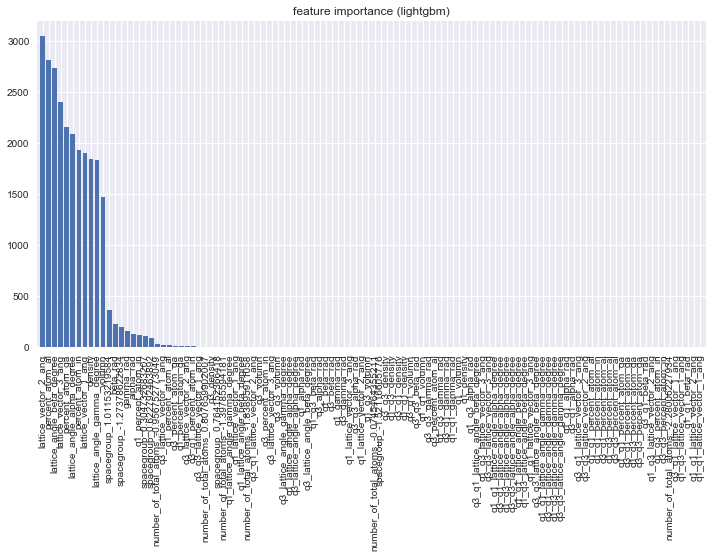

best cv mean 0.00102686225368
lgb cv and training...
best round 2715
best mse-mean 0.0074269941356
lgb cv and training finished...


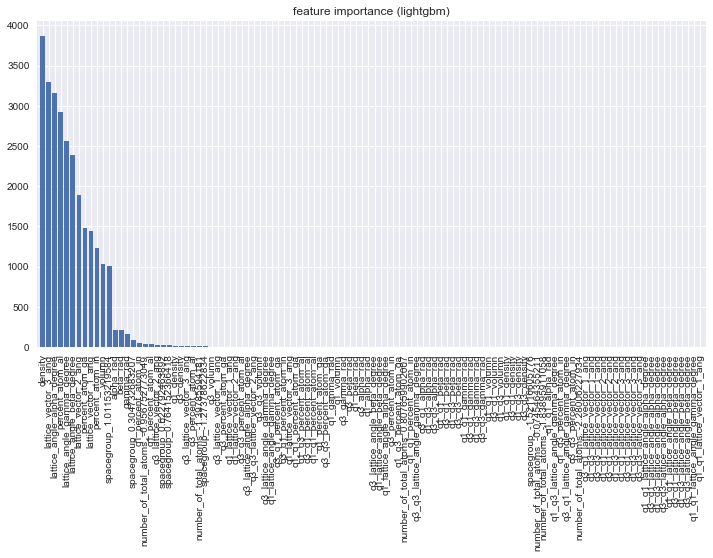

best cv mean 0.0074269941356
0.0591123507875


In [36]:
best_cv_mean_fe, feat_weight_fe, model_lgb_fe = get_model_cv(X, target_fe)

# 恢复log前的值
pred_fe = np.expm1(model_lgb_fe.predict(TEST))

best_cv_mean_be, feat_weight_be, model_lgb_be = get_model_cv(X, target_be)
pred_be = np.expm1(model_lgb_be.predict(TEST))

scr_total = np.mean([np.sqrt(best_cv_mean_fe), np.sqrt(best_cv_mean_be)])
print(scr_total)

sub = pd.read_csv('sample_submission.csv')
sub['formation_energy_ev_natom'] = pred_fe
sub['bandgap_energy_ev'] = pred_be
sub.to_csv('gbm.csv', index=False)

### Result

In [46]:
xgb = XGBRegressor(max_depth = 4)
xgb.fit(X, y['bandgap_energy_ev'])
y_band = xgb.predict(TEST)

In [47]:
xgb = XGBRegressor(max_depth = 4)
xgb.fit(X, y['formation_energy_ev_natom'])
y_format = xgb.predict(TEST)

In [48]:
id = [x for x in range(1, 601)]
submit = pd.DataFrame({'id': id,'formation_energy_ev_natom':y_format,'bandgap_energy_ev':y_band})
submit = submit[['id', 'formation_energy_ev_natom', 'bandgap_energy_ev']]

In [49]:
submit.to_csv('conductor.csv',index=False)